In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import scipy.stats as stats
import missingno as msno

In [80]:
def get_user_list(loc):
    # Collecting all student codes from activity folder (which represents all students)
    user_codes = []
    for x in sorted(os.listdir(loc + 'sensing/activity/')):
        # Chooses the string before "." and after "_"
        user_codes.append(x.split('.')[0].split('_')[1])
    return user_codes

In [81]:
def get_activity(user, loc):
    activity = pd.read_csv(loc + 'sensing/activity/activity_' + user + '.csv')
    activity.columns = ['timestamp', 'activity_inference']
    # make timestamp unique and take the mode for different values of activity inference
    activity = activity.groupby("timestamp")['activity_inference'].apply(lambda x: x.mode()[0]).reset_index()
    activity.timestamp = pd.to_datetime(activity.timestamp, unit='s')
    activity = activity.set_index('timestamp')
    activity = activity.asfreq('s', method='bfill')
    return activity


def get_audio(user, loc):
    audio = pd.read_csv(loc + 'sensing/audio/audio_' + user + '.csv')
    audio.columns = ['timestamp', 'audio_inference']
    # make timestamp unique and take the mode for different values of audio inference
    audio = audio.groupby("timestamp")['audio_inference'].apply(lambda x: x.mode()[0]).reset_index()
    audio.timestamp = pd.to_datetime(audio.timestamp, unit='s')
    audio = audio.set_index('timestamp')
    audio = audio.asfreq('s', method='bfill')
    return audio

def get_conversation(user, loc):
    conversation = pd.read_csv(loc + 'sensing/conversation/conversation_' + user + '.csv')
    conversation.columns = ['start_timestamp', 'end_timestamp']
    conversation.start_timestamp = pd.to_datetime(conversation.start_timestamp, unit='s')
    conversation.end_timestamp = pd.to_datetime(conversation.end_timestamp, unit='s')
    return conversation

def get_bluetooth(user, loc):
    bluetooth = pd.read_csv(loc + 'sensing/bluetooth/bt_' + user + '.csv', index_col=False)
    bluetooth.time = pd.to_datetime(bluetooth.time, unit='s')
    return bluetooth

def get_wifi(user, loc):
    wifi = pd.read_csv(loc + 'sensing/wifi/wifi_' + user + '.csv', index_col=False)
    wifi.time = pd.to_datetime(wifi.time, unit='s')
    return wifi

def get_wifi_loc(user, loc):
    wifi_loc = pd.read_csv(loc + 'sensing/wifi_location/wifi_location_' + user + '.csv', index_col=False)
    wifi_loc.time = pd.to_datetime(wifi_loc.time, unit='s')
    return wifi_loc

def get_dark(user, loc):
    dark = pd.read_csv(loc + 'sensing/dark/dark_' + user + '.csv', index_col=False)
    dark.start = pd.to_datetime(dark.start, unit='s')
    dark.end = pd.to_datetime(dark.end, unit='s')
    return dark

def get_phone_charge(user, loc):
    phonecharge = pd.read_csv(loc + 'sensing/phonecharge/phonecharge_' + user + '.csv', index_col=False)
    phonecharge.start = pd.to_datetime(phonecharge.start, unit='s')
    phonecharge.end = pd.to_datetime(phonecharge.end, unit='s')
    return phonecharge

def get_phone_lock(user, loc):
    phonelock = pd.read_csv(loc + 'sensing/phonelock/phonelock_' + user + '.csv', index_col=False)
    phonelock.start = pd.to_datetime(phonelock.start, unit='s')
    phonelock.end = pd.to_datetime(phonelock.end, unit='s')
    return phonelock

In [82]:
def merge_sensing_data(activity, audio, conversation, bluetooth, wifi, wifi_loc, dark, phone_charge, phone_lock):
    # activity - audio merge
    df = pd.merge(activity, audio, left_index=True, right_index=True, how='outer')
    df = df.reset_index()

    # add conversation
    df['conversation'] = np.nan
    for i in range(conversation.shape[0]):
        start = conversation.iloc[i, 0]
        end = conversation.iloc[i, 1]
        df.loc[(df['timestamp'] >= start) & (df['timestamp'] <= end), 'conversation'] = 1

    # add bluetooth
    bluetooth_new = pd.DataFrame()
    for time in bluetooth.time.unique():
        data = {'timestamp': time}
        item = bluetooth[bluetooth.time == time]
        data['total_devices_around'] = item.shape[0]
        data['total_nearer'] = item[item.level >= -70].shape[0]
        data['total_near'] = item[(item.level >= -80) & (item.level < -70)].shape[0]
        data['total_far'] = item[(item.level >= -90) & (item.level < -80)].shape[0]
        data['total_farther'] = item[(item.level >= -100) & (item.level < -90)].shape[0]
        data['level_avg'] = round(item.level.mean())
        data['level_std'] = item.level.std()
        bluetooth_new = bluetooth_new.append(data, ignore_index=True)

    bluetooth_new.columns = ['bt_' + i for i in bluetooth_new.columns]
    df = pd.merge(df, bluetooth_new, left_on='timestamp', right_on='bt_timestamp', how='outer')
    df.drop(columns=['bt_timestamp'], inplace=True)

    # add wifi
    wifi_new = pd.DataFrame()
    for time in wifi.time.unique():
        data = {'timestamp': time}
        item = wifi[wifi.time == time]
        data['total_devices_around'] = item.shape[0]
        data['total_nearer'] = item[item.level >= -60].shape[0]
        data['total_near'] = item[(item.level >= -80) & (item.level < -60)].shape[0]
        data['total_far'] = item[(item.level >= -100) & (item.level < -80)].shape[0]
        data['level_avg'] = round(item.level.mean())
        data['level_std'] = item.level.std()
        wifi_new = wifi_new.append(data, ignore_index=True)

    wifi_new.columns = ['wifi_' + i for i in wifi_new.columns]
    df = pd.merge(df, wifi_new, left_on='timestamp', right_on='wifi_timestamp', how='left')
    df.drop(columns=['wifi_timestamp'], inplace=True)

    # add dark
    df['phone_in_dark'] = np.nan
    for i in range(dark.shape[0]):
        start = dark.iloc[i, 0]
        end = dark.iloc[i, 1]
        df.loc[(df['timestamp'] >= start) & (df['timestamp'] <= end), 'phone_in_dark'] = 1

    # phone charge
    df['phone_charging'] = np.nan
    for i in range(phone_charge.shape[0]):
        start = phone_charge.iloc[i, 0]
        end = phone_charge.iloc[i, 1]
        df.loc[(df['timestamp'] >= start) & (df['timestamp'] <= end), 'phone_charging'] = 1

    # phone locked
    df['phone_locked'] = np.nan
    for i in range(phone_lock.shape[0]):
        start = phone_lock.iloc[i, 0]
        end = phone_lock.iloc[i, 1]
        df.loc[(df['timestamp'] >= start) & (df['timestamp'] <= end), 'phone_locked'] = 1

    return df

In [83]:
### EMA FUNCTIONS ###
def ema(user, typ, cols, loc):
    data = pd.read_json(loc + 'EMA/response/' + typ + '/' + typ + '_' + user + '.json')
    if 'null' in data.columns:
        data = data.drop(columns='null')
    if 'location' in data.columns:
        data = data.drop(columns='location')
    dr = True
    for j in cols:
        if j not in data.columns:
            dr = False
    if dr == True:
        data = data.dropna(subset=cols)
    return data

In [84]:
def label_generator(stress, mood2, resample_factor):
    stress['level'] = stress['level'].replace([1,2,3], 1)
    stress['level'] = stress['level'].replace([4,5], 0)
    stress.columns = ['STRESSED', 'resp_time']
    mood2 = mood2.replace([1, 3], 0)
    mood2 = mood2.replace([2], 1)
    mood2.columns = ['STRESSED', 'resp_time']
    labels = stress.append(mood2)
    labels = labels.sort_values(by='resp_time', ascending=True)
    labels = labels.set_index('resp_time').resample(resample_factor).max()
    labels = labels[labels.STRESSED.notnull()]
    return labels

In [85]:
def create_instances(df, labels, counter):
    starting_label_index = 0

    # Finds out the timestamp of first label that have data.
    for i in range(len(labels)):
        if labels.index[i] > df.index[i]:
            starting_label_index = i
            break
        else:
            continue

    all_data = {}

    # Creates first instance of dataset.
    start = labels.index[starting_label_index]
    instance = df[df.index <= start].values
    output = labels.loc[start].values[0]
    one_data = {'instance': instance, 'label': output}
    all_data[0] = one_data

    # Loop to create instances.
    for i in range(starting_label_index + 1, len(labels[starting_label_index:]), 1):
        end = labels.index[i]
        instance = df[(df.index > start) & (df.index <= end)].values
        if instance.shape[0] == 0:
            continue
        output = labels.loc[end].values[0]
        one_data = {'instance': instance, 'label': output}
        all_data[counter] = one_data
        start = end
        counter += 1

    return all_data, counter

In [86]:
# Set dataset directory
dir_loc = '../../student-life-study-data/dataset/'

In [87]:
# Get user list
user_codes = get_user_list(dir_loc)

In [88]:
user = 'u13'

In [89]:
# Sensing
activity = get_activity(user, dir_loc)
audio = get_audio(user, dir_loc)
conversation = get_conversation(user, dir_loc)
bluetooth = get_bluetooth(user, dir_loc)
wifi = get_wifi(user, dir_loc)
wifi_loc = get_wifi_loc(user, dir_loc)
dark = get_dark(user, dir_loc)
phone_charge = get_phone_charge(user, dir_loc)
phone_lock = get_phone_lock(user, dir_loc)
# EMA
stress = ema(user, 'Stress', ['level'], dir_loc)
mood2 = ema(user, 'Mood 2', ['how'], dir_loc)

print('Data read is completed.')

Data read is completed.


In [42]:
df = merge_sensing_data(activity, audio, conversation,
                        bluetooth, wifi, wifi_loc, dark,
                        phone_charge, phone_lock)

print('Data merge is completed.')

Data merge is completed.


In [43]:
df.head()

,timestamp,activity_inference,audio_inference,conversation,bt_level_avg,bt_level_std,bt_total_devices_around,bt_total_far,bt_total_farther,bt_total_near,bt_total_nearer,wifi_level_avg,wifi_level_std,wifi_total_devices_around,wifi_total_far,wifi_total_near,wifi_total_nearer,phone_in_dark,phone_charging,phone_locked
0,2013-03-27 04:00:01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-03-27 04:00:02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-27 04:00:03,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-03-27 04:00:04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-03-27 04:00:05,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


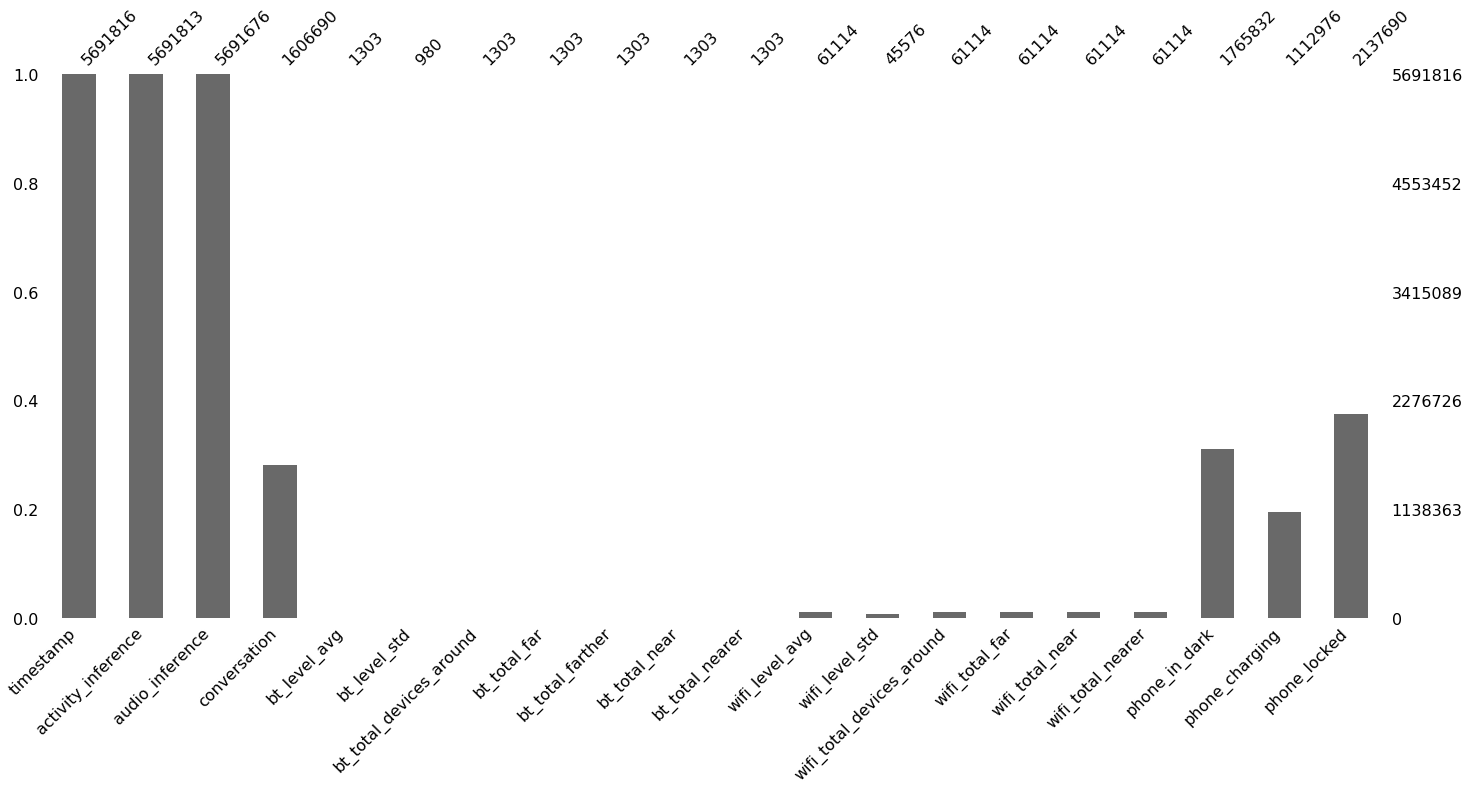

In [44]:
msno.bar(df)

In [45]:
# Create labels
if stress.shape[1] == 2:
    stress['level'] = stress['level'].replace([1,2,3], 1)
    stress['level'] = stress['level'].replace([4,5], 0)
    stress.columns = ['STRESSED', 'resp_time']

if mood2.shape[1] == 2:
    mood2 = mood2.replace([1, 3], 0)
    mood2 = mood2.replace([2], 1)
    mood2.columns = ['STRESSED', 'resp_time']

labels = stress.append(mood2)
labels = labels.sort_values(by='resp_time', ascending=True)

In [96]:
labels.shape

(89, 1)

In [53]:
df.activity_inference.value_counts()

0.0    4626416
1.0     772439
3.0     196953
2.0      96008
Name: activity_inference, dtype: int64

In [54]:
df.audio_inference.value_counts()

0.0    3142274
2.0    1442295
1.0    1107107
3.0        140
Name: audio_inference, dtype: int64

In [17]:
# # Change values to make them reasonable for resample method.
# # 0: Unknown, 1: Stationary, 2: Walking, 3: Running
# df['activity_inference'] = df['activity_inference'].replace([0,1,2,3], [1,2,3,0])
# # 0: Unknown, 1: Silence, 2: Noise, 3: Voice
# df['audio_inference'] = df['audio_inference'].replace([0,1,2,3], [1,3,2,0])

In [49]:
df = df[df.timestamp.notnull()]

In [ ]:
# activity_inference
# 0: Stationary, 1: Walking, 2: Running, 3: Unknown

# audio_inference
# 0: Silence, 1: Voice, 2: Noise, 3: Unknown

In [50]:
# Fill empty values in dataset.
df.loc[:, ['activity_inference',
           'audio_inference']] = df.loc[:, ['activity_inference',
                                             'audio_inference']].fillna(value=3)

In [51]:
# Fill empty values in dataset.
df.loc[:, ['conversation',
            'phone_in_dark',
            'phone_charging',
            'phone_locked']] = df.loc[:, ['conversation',
                                        'phone_in_dark',
                                        'phone_charging',
                                        'phone_locked']].fillna(value=0)

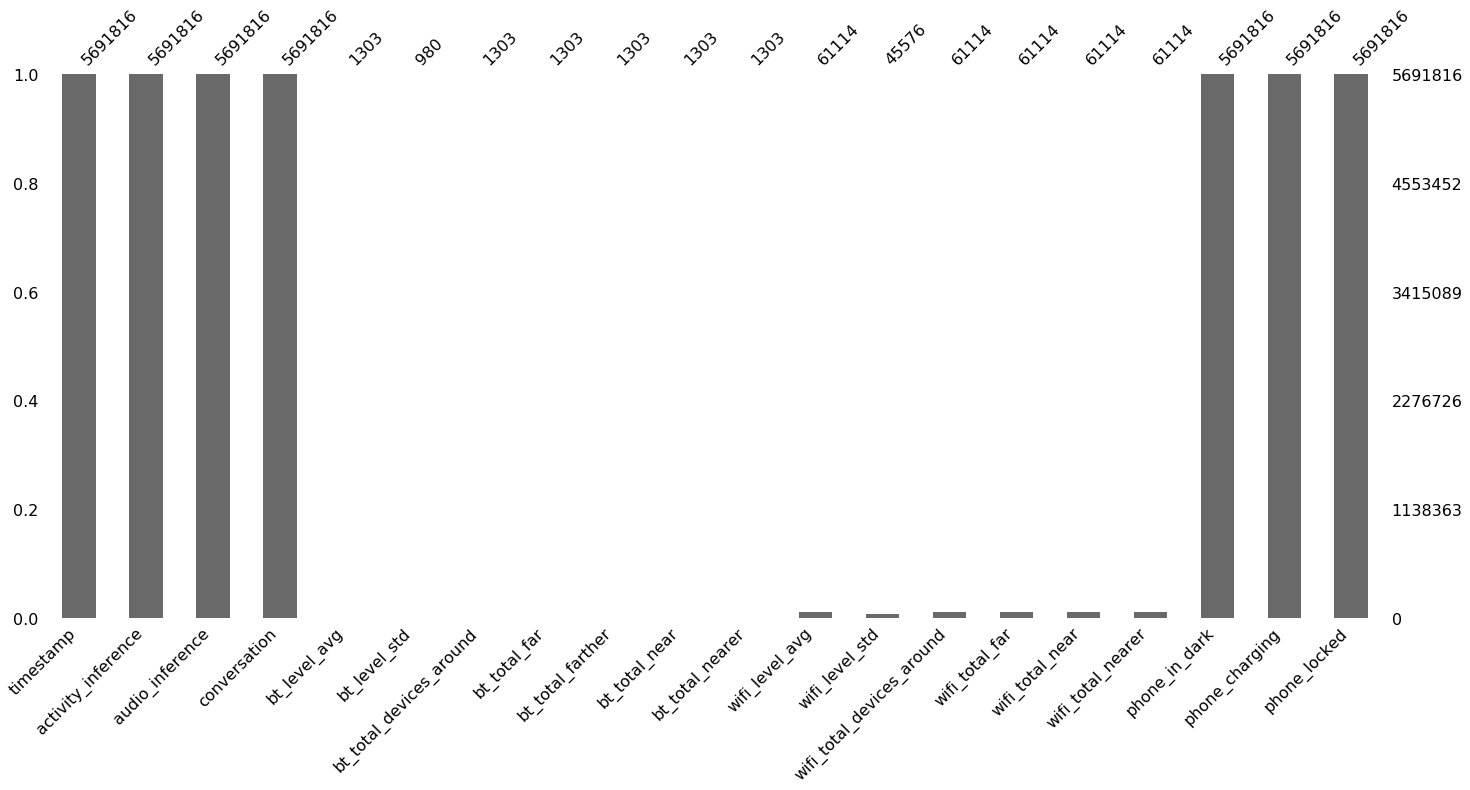

In [52]:
msno.bar(df)

In [55]:
df.head()

,timestamp,activity_inference,audio_inference,conversation,bt_level_avg,bt_level_std,bt_total_devices_around,bt_total_far,bt_total_farther,bt_total_near,bt_total_nearer,wifi_level_avg,wifi_level_std,wifi_total_devices_around,wifi_total_far,wifi_total_near,wifi_total_nearer,phone_in_dark,phone_charging,phone_locked
0,2013-03-27 04:00:01,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,2013-03-27 04:00:02,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,2013-03-27 04:00:03,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,2013-03-27 04:00:04,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,2013-03-27 04:00:05,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [56]:
df.loc[:, ['activity_inference', 
           'audio_inference']] = df.loc[:, ['activity_inference', 
                                            'audio_inference']].astype(int)

In [57]:
df['activity_inference'] = df['activity_inference'].astype('category')
df['audio_inference'] = df['audio_inference'].astype('category')

In [58]:
df = pd.get_dummies(df)

In [59]:
df.columns

Index(['timestamp', 'conversation', 'bt_level_avg', 'bt_level_std',
       'bt_total_devices_around', 'bt_total_far', 'bt_total_farther',
       'bt_total_near', 'bt_total_nearer', 'wifi_level_avg', 'wifi_level_std',
       'wifi_total_devices_around', 'wifi_total_far', 'wifi_total_near',
       'wifi_total_nearer', 'phone_in_dark', 'phone_charging', 'phone_locked',
       'activity_inference_0', 'activity_inference_1', 'activity_inference_2',
       'activity_inference_3', 'audio_inference_0', 'audio_inference_1',
       'audio_inference_2', 'audio_inference_3'],
      dtype='object')

In [60]:
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index, unit='s')

In [65]:
def resample_dict(columns):
    agg_dict = {}
    for i in columns:
        if ('conversation' in i) | ('phone' in i) | ('inference' in i):
            agg_dict[i] = np.sum
        elif 'level' in i:
            agg_dict[i] = np.mean
        elif 'total' in i:
            agg_dict[i] = np.max
    return agg_dict

In [69]:
res_dict = resample_dict(list(df.columns))

In [73]:
df = df.resample('10min').agg(res_dict)

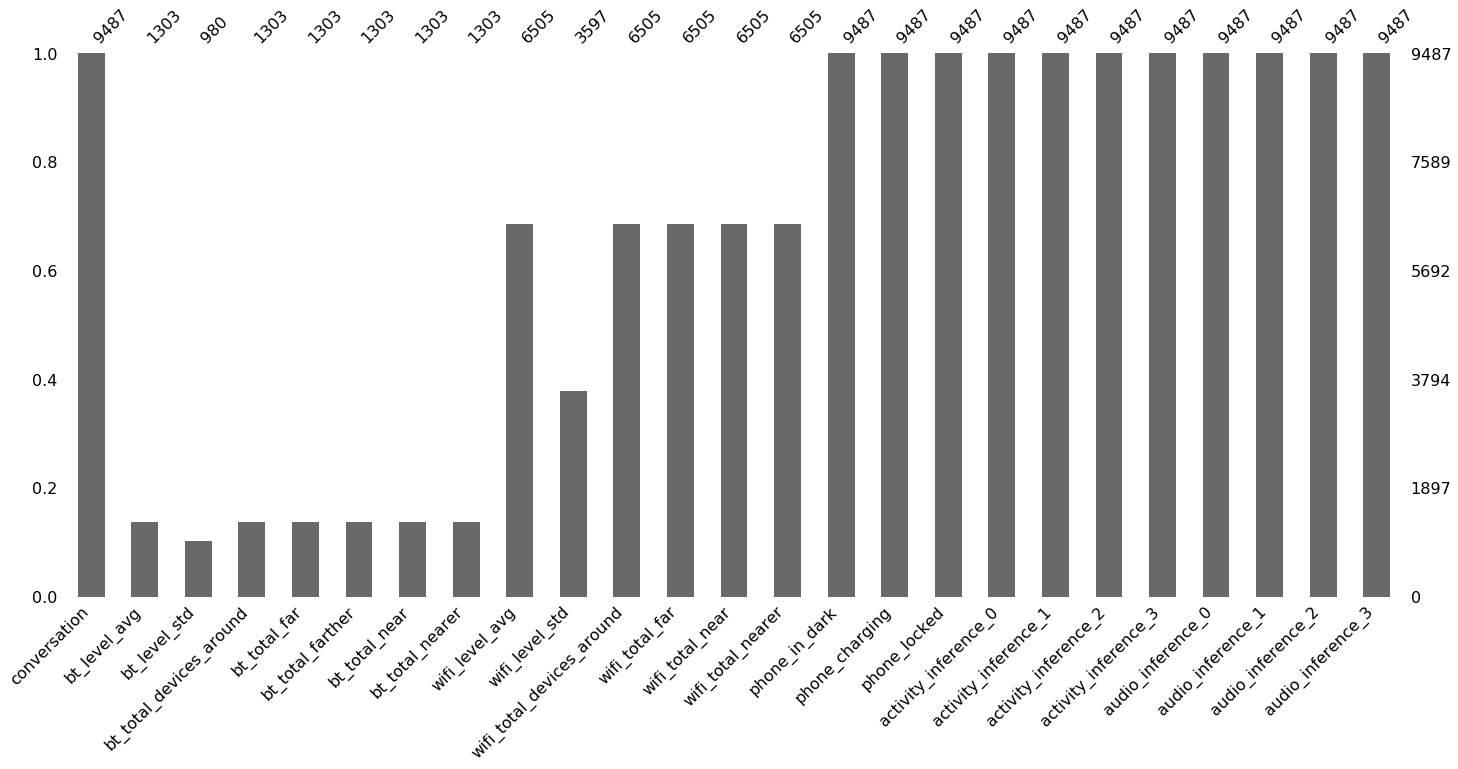

In [74]:
msno.bar(df)

In [75]:
labels = labels.set_index('resp_time')

In [76]:
labels

,STRESSED
resp_time,
2013-03-25 18:54:56,1.0
2013-03-26 03:33:26,1.0
2013-03-26 03:33:34,1.0
2013-03-27 01:12:20,1.0
2013-03-28 02:25:27,1.0
2013-03-28 18:43:12,1.0
2013-03-28 19:17:25,1.0
2013-03-28 19:25:54,1.0
2013-03-28 21:08:14,0.0


In [77]:
df_comb = pd.merge_asof(df, labels, left_index=True, right_index=True, tolerance=pd.Timedelta('10m'))

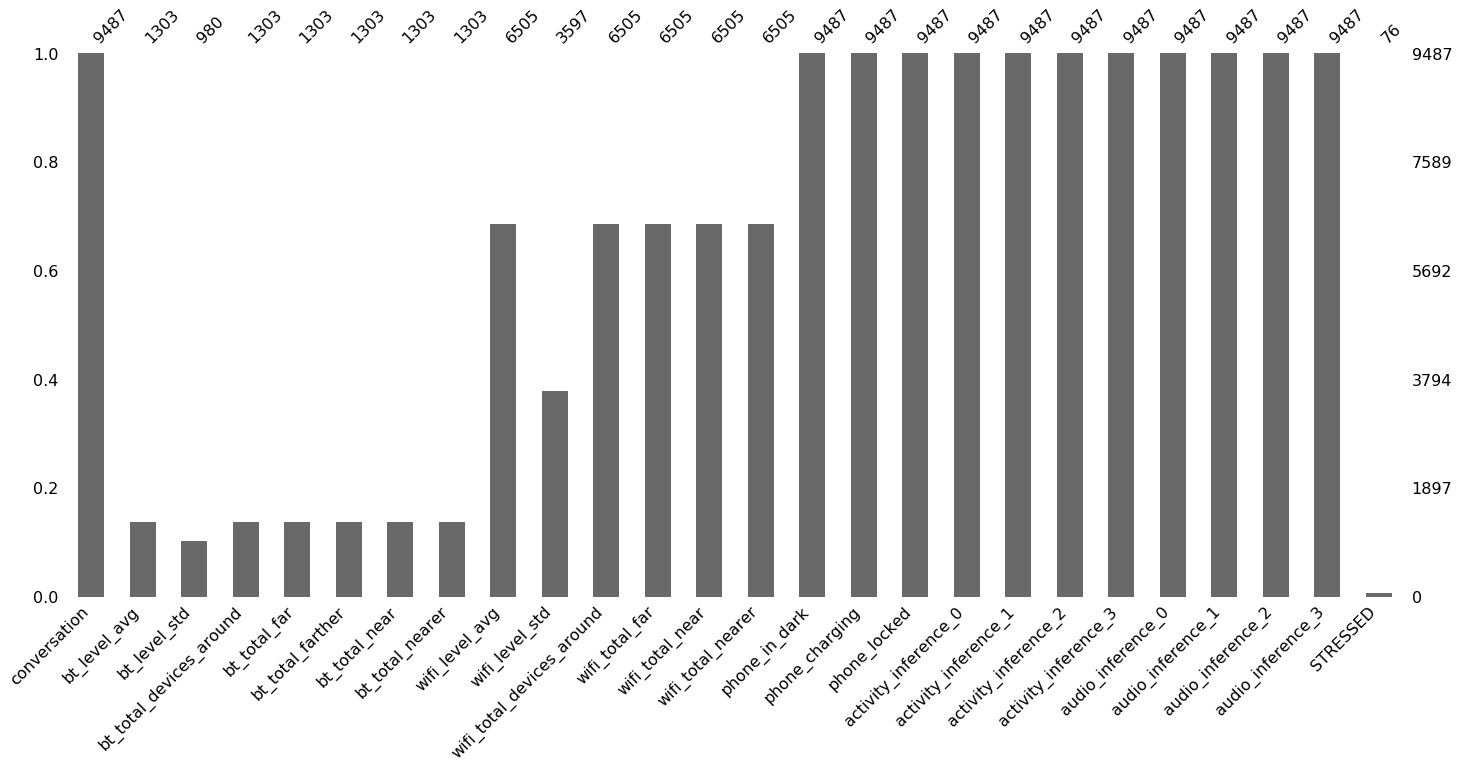

In [78]:
msno.bar(df_comb)